## Training Dataset
### References
- [Pokemon Dataset](https://www.kaggle.com/datasets/rounakbanik/pokemon?resource=download)
- [Detailed Analysis and Model Training](https://www.kaggle.com/code/shobhit043/detailed-analysis-and-model-training-98-acc)<br>
- [Nickname Generation with Recurrent Neural Networks - Medium](https://medium.com/data-science-and-machine-learning-at-pluralsight/nickname-generation-with-recurrent-neural-networks-with-pytorch-6fa53de7f289)
- [CharLSTM Gist](https://gist.github.com/jrwalk/9ceee8707f01a324e72fbbe3ebc37e51#file-char_lstm-py)
- [Generic PyTorch Text Generator w/ Character LSTM](https://www.youtube.com/watch?v=WujVlF_6h5A)
- [PyTorch CharRNN Tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)

## Generate Pokemon Names with CharLTSM

### Imports

In [7]:
import pandas as pd
import numpy as np

### Data Preprocessing
- concatenate all the pokemon names together to make sequences
- create a charset and get length
- build encoding and decoding maps
- set the max sequence length

In [8]:
# References
# https://github.com/simon-larsson/pokemon-name-generator/blob/master/name_generator.ipynb

# export pokemon names to a list, then save this to a names file
df = pd.read_csv('/Users/waslow/Data/pokemon.csv')
pokemon_names = df['name'].tolist()

# check the list
print('First 5 pokemon names:')
print(pokemon_names[:5])
print('\n')

# Preprocess the data to train the name model
concatenated_names = '\n'.join(pokemon_names).lower()

# find all unique characters in the names using set
chars = sorted(list(set(concatenated_names)))
num_chars = len(chars)

# Build translation dictionaries, 'a' -> 0, 0 -> 'a'
char2idx = dict((c, i) for i, c in enumerate(chars))
idx2char = dict((i, c) for i, c in enumerate(chars))

# Use longest name length as our sequence window
max_sequence_length = max([len(name) for name in pokemon_names])

# some stats
print('Chars:')
print(chars)
print('\n')

print('Total chars: {}'.format(num_chars))
print('Corpus length:', len(concatenated_names))
print('Number of names: ', len(pokemon_names))
print('Longest name: ', max_sequence_length)

First 5 pokemon names:
['Bulbasaur', 'Ivysaur', 'Venusaur', 'Charmander', 'Charmeleon']


Chars:
['\n', ' ', "'", '-', '.', '2', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é', '♀', '♂']


Total chars: 36
Corpus length: 6780
Number of names:  801
Longest name:  12


### Make a training dataset
Slide a window of size sequence length across the pokemon name concatentation to generate training feature sets.
The next char at each step is the label.

In [9]:
sequences = []
next_chars = []
step_length = 1

# Slide a window of size max_sequence_length over the data
# to create a training set
for i in range(0, len(concatenated_names) - max_sequence_length, step_length):
    sequences.append(concatenated_names[i: i + max_sequence_length])
    next_chars.append(concatenated_names[i + max_sequence_length])

num_sequences = len(sequences)

print('Number of sequences:', num_sequences)
print('First 10 sequences and next chars:')
for i in range(10):
    print('X=[{}]   y=[{}]'.replace('\n', ' ').format(sequences[i], next_chars[i]).replace('\n', ' '))

Number of sequences: 6768
First 10 sequences and next chars:
X=[bulbasaur iv]   y=[y]
X=[ulbasaur ivy]   y=[s]
X=[lbasaur ivys]   y=[a]
X=[basaur ivysa]   y=[u]
X=[asaur ivysau]   y=[r]
X=[saur ivysaur]   y=[ ]
X=[aur ivysaur ]   y=[v]
X=[ur ivysaur v]   y=[e]
X=[r ivysaur ve]   y=[n]
X=[ ivysaur ven]   y=[u]


Convert these into 3D numpy arrays

In [10]:
X = np.zeros((num_sequences, max_sequence_length, num_chars), dtype=int)
Y = np.zeros((num_sequences, num_chars), dtype=int)

for i, sequence in enumerate(sequences):
    for j, char in enumerate(sequence):
        X[i, j, char2idx[char]] = 1
    Y[i, char2idx[next_chars[i]]] = 1
    
print('X shape: {}'.format(X.shape))
print('Y shape: {}'.format(Y.shape))

X shape: (6768, 12, 36)
Y shape: (6768, 36)


In [11]:
# explore data
print('X')
print(type(X[0]))
print(X[0].shape)
print('First training example:')
print(X[0])
print('First character of first training example encoding:')
print(X[0][0])
print('Decoded:')
print([idx2char[np.argmax(char_vec)] for char_vec in X[0]])
print('\n')

print('Y')
print(type(Y[0]))
print(Y[0].shape)
print('Frist training example label:')
print(Y[0])
print('Decoded:')
print(idx2char[np.argmax(Y[0])])
print('\n')

print('encoding dictionary')
print(char2idx)
print('decoding dictionary')
print(idx2char)
print('\n')

# this all looks good
from torch import from_numpy
x_tensor = from_numpy(X)
print(type(x_tensor))
# print(x_tensor)
print(x_tensor.shape)
print(x_tensor.squeeze().shape)

# convert data back to words


X
<class 'numpy.ndarray'>
(12, 36)
First training example:
[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
First character of first training exampl

### PyTorch Embedding Block
Using an example, create a char embedding layer for the pokemon name charset.

In [207]:
import torch
import torch.nn as nn
import torch.optim as optim

References:
- Guide to PyTorch Embedding Layer [https://hussainwali.medium.com/guide-to-pytorchs-embedding-layer-68913ee53d2e]
- PyTorch Embedding Docs [https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html]

#### Example

In [267]:
# explore/configure embedding layer
# references:
# https://hussainwali.medium.com/guide-to-pytorchs-embedding-layer-68913ee53d2e
# https://ai.stackexchange.com/questions/28564/how-to-determine-the-embedding-size
#    "Older papers in NLP used 300 conventionally https://petuum.medium.com/embeddings-a-matrix-of-meaning-4de877c9aa27.
#     More recent papers used 512, 768, 1024."

# example
sentences = ["I love cats",  
  "I hate dogs",    
  "Cats are cute",  
  "Dogs are loyal"
]
vocab = list(set(word for sentence in sentences for word in sentence.split()))
word_to_index = {word: i for i, word in enumerate(vocab)}
sentences_indices = [
    [word_to_index[word] for word in sentence.split()]
    for sentence in sentences
]

# ------------------------------------------------------------
#                    OUTPUT
# ------------------------------------------------------------
# vocab = ['love', 'Dogs', 'Cats', 'cats', 'are', 'cute', 'dogs', 'loyal', 'hate', 'I']
# word_to_index = {'love': 0, 'Dogs': 1, 'Cats': 2, 'cats': 3, 'are': 4, 'cute': 5, 'dogs': 6, 'loyal': 7, 'hate': 8, 'I': 9}
# sentences_indices = [[9, 0, 3], [9, 8, 6], [2, 4, 5], [1, 4, 7]]
# ------------------------------------------------------------
print('example')
print(f"vocab: {vocab}")
print(f"conversion: {word_to_index}")
print(f"sequences: {sentences}")
print(f"sequences indices: {sentences_indices}")

example
vocab: ['love', 'are', 'I', 'hate', 'Dogs', 'cute', 'cats', 'loyal', 'dogs', 'Cats']
conversion: {'love': 0, 'are': 1, 'I': 2, 'hate': 3, 'Dogs': 4, 'cute': 5, 'cats': 6, 'loyal': 7, 'dogs': 8, 'Cats': 9}
sentences: ['I love cats', 'I hate dogs', 'Cats are cute', 'Dogs are loyal']
sentences_indices: [[2, 0, 6], [2, 3, 8], [9, 1, 5], [4, 1, 7]]


#### Pokemon Names

In [270]:
# pokemon sequence
concat_poke_names = '\n'.join(pokemon_names).lower() # replace newline with <EOS>
charset = sorted(list(set(concat_poke_names)))
char_to_idx = dict((c, i) for i, c in enumerate(charset))
sequences_indices = [
    [char_to_idx[char.lower()] for char in name] for name in pokemon_names
]

print('pokemon')
print(f"vocab: {charset}")
print(f"conversion: {char_to_idx}")
print(f"sequences: {sequences}")
print(f"sequences indices: {sequences_indices}")

# pokemon data matches example data

pokemon
vocab: ['\n', ' ', "'", '-', '.', '2', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é', '♀', '♂']
conversion: {'\n': 0, ' ': 1, "'": 2, '-': 3, '.': 4, '2': 5, ':': 6, 'a': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'h': 14, 'i': 15, 'j': 16, 'k': 17, 'l': 18, 'm': 19, 'n': 20, 'o': 21, 'p': 22, 'q': 23, 'r': 24, 's': 25, 't': 26, 'u': 27, 'v': 28, 'w': 29, 'x': 30, 'y': 31, 'z': 32, 'é': 33, '♀': 34, '♂': 35}
sequences: ['bulbasaur\niv', 'ulbasaur\nivy', 'lbasaur\nivys', 'basaur\nivysa', 'asaur\nivysau', 'saur\nivysaur', 'aur\nivysaur\n', 'ur\nivysaur\nv', 'r\nivysaur\nve', '\nivysaur\nven', 'ivysaur\nvenu', 'vysaur\nvenus', 'ysaur\nvenusa', 'saur\nvenusau', 'aur\nvenusaur', 'ur\nvenusaur\n', 'r\nvenusaur\nc', '\nvenusaur\nch', 'venusaur\ncha', 'enusaur\nchar', 'nusaur\ncharm', 'usaur\ncharma', 'saur\ncharman', 'aur\ncharmand', 'ur\ncharmande', 'r\ncharmander', '\ncharmander\

#### Example

In [278]:
# # example
# # make the embedding tensor
# # specify the size of the vocabulary and the size of the embedding vectors
# vocab_size = len(vocab)
# embedding_dim = 10
# # initialize the embedding layer
# embedding = nn.Embedding(vocab_size, embedding_dim)

# ex
# Define the number of words in our vocabulary
vocab_size = 100
# Define the size of the embedding vectors
embedding_dim = 10
# Create the embedding layer
embedding = nn.Embedding(vocab_size, embedding_dim)
# Convert a single sentence into its word indices
sentence = "I love cats"
sentence_indices = [word_to_index[word] for word in sentence.split()]
# Convert the word indices into embedding vectors
embedded = embedding(torch.tensor(sentence_indices))


print(f"vocab size: {vocab_size}")
print(f"embedding dim: {embedding_dim}")
print(f"embedding: {embedding}")
print(f"sentence: {sentence}")
print(f"sentence indices: {sentence_indices}")
print(f"embedded: {embedded}")
print(f"embedded shape: {embedded.shape}")

vocab size: 100
embedding dim: 10
embedding: Embedding(100, 10)
sentence: I love cats
sentence indices: [2, 0, 6]
embedded: tensor([[ 1.2330, -0.7732,  0.5322,  0.0815,  0.0598,  0.1531, -0.4342, -2.7900,
         -0.3904, -1.8033],
        [ 0.7432, -0.6819, -0.9505, -0.7113, -0.9575, -1.1781,  0.2006, -0.7667,
         -0.6312, -0.1671],
        [ 2.4708, -0.1161,  0.5400, -0.3955, -0.2184, -1.7792, -0.4249,  1.7215,
         -1.1600,  0.3187]], grad_fn=<EmbeddingBackward0>)
embedded shape: torch.Size([3, 10])


#### Pokemon Name Dataset

In [289]:
# pokemon
vocab_size = len(charset)
embedding_dim = 10
# init the embedding layer
embedding = nn.Embedding(vocab_size, embedding_dim) # embedding dimension is hyperparameter for performance tuning
# convert a single name into its char indices
name = sequences[0] # sentence

def tensorize(seq):
    return torch.tensor([char_to_idx[char] for char in seq])

# name_indices = [char_to_idx[char] for char in name]
# # convert the char indices into embedding vectors
# embedded = embedding(torch.tensor(name_indices))

name_indices = tensorize(name)
embedded = embedding(name_indices)


print(f"vocab size: {vocab_size}")
print(f"embedding dim: {embedding_dim}")
print(f"embedding: {embedding}")
p_name = name.replace('\n', '|') # here '|' is the end of the string
print(f"name: {p_name}")
print(f"name indices: {name_indices}")
print(f"embedded: {embedded}")
print(f"embedded shape: {embedded.shape}")

vocab size: 36
embedding dim: 10
embedding: Embedding(36, 10)
name: bulbasaur|iv
name indices: tensor([ 8, 27, 18,  8,  7, 25,  7, 27, 24,  0, 15, 28])
embedded: tensor([[ 0.9898, -0.0349,  2.3644, -0.2203,  0.5044,  0.5789,  0.6832, -1.6920,
         -0.4323,  0.2254],
        [ 0.2214, -0.4710, -0.5418, -1.0338, -0.9362,  0.2613, -0.3115, -1.5339,
          0.4658, -0.5778],
        [-0.9969, -0.2681,  0.1921, -0.4956,  0.3453,  2.4331, -0.4087, -0.3401,
          0.9686, -1.1243],
        [ 0.9898, -0.0349,  2.3644, -0.2203,  0.5044,  0.5789,  0.6832, -1.6920,
         -0.4323,  0.2254],
        [-0.8451,  0.0274,  0.0156,  1.8899,  0.8491, -0.1831, -0.4986,  0.5399,
         -0.1202,  0.3308],
        [ 0.5325,  0.9132,  0.2398, -0.0883, -1.6686,  0.2965, -0.2649, -1.7336,
         -0.0994, -2.1278],
        [-0.8451,  0.0274,  0.0156,  1.8899,  0.8491, -0.1831, -0.4986,  0.5399,
         -0.1202,  0.3308],
        [ 0.2214, -0.4710, -0.5418, -1.0338, -0.9362,  0.2613, -0.3115, -1.

### PyTorch CharLSTM Dataset Management

#### As a script

In [291]:
import os
import pprint

pp = pprint.PrettyPrinter(indent=4)

# load the data
pokemon_names = []
# check to see if pokemon_names.csv exists
if os.path.exists('/Users/waslow/Data/pokemon_names.csv'):
    # read the names into a list
    with open('/Users/waslow/Data/pokemon_names.csv', 'r') as f:
        pokemon_names = f.read().split('\n')
else:
    # read the pokemon names csv into a df
    df = pd.read_csv('/Users/waslow/Data/pokemon.csv')
    pokemon_names = df['name'].tolist()

    # save the names to a file
    with open('/Users/waslow/Data/pokemon_names.csv', 'w') as f:
        f.write('\n'.join(pokemon_names))

print(f"pokemon names: {pokemon_names}")

# all pokemon concatenated together
# used to predict the next character
corpus = '\n'.join(pokemon_names).lower()

p_corpus = corpus.replace('\n', '|') # here '|' is the end of the string
print(f"corpus: {p_corpus}")

# find all unique characters in the names using set
chars = sorted(list(set(corpus)))
num_chars = len(chars)

print(f"chars: {chars}")
print(f"num chars: {num_chars}")

# Build translation dictionaries, 'a' -> 0, 0 -> 'a'
encoding = dict((c, i) for i, c in enumerate(chars))
decoding = dict((i, c) for i, c in enumerate(chars))

print(f"encoding: {encoding}")
print(f"decoding: {decoding}")

def encode(key):
    return encoding[key]

def decode(key):
    return decoding[key]

# Use longest name length as our sequence window
sequence_length = max([len(name) for name in pokemon_names]) # max sequence length
corpus_length = len(concatenated_names)

print(f"sequence length: {sequence_length}")
print(f"corpus length: {corpus_length}")

raw_features = [] # sequences
raw_labels = [] # next_chars
step_length = 1 

# slide a window of size sequence_length over the data
# to create a training set
for i in range(0, corpus_length - sequence_length, step_length):
    raw_features.append(corpus[i: i + sequence_length])
    raw_labels.append(corpus[i + sequence_length])

num_features = len(raw_features)

print(f"raw feature/label pairs: {list(zip(raw_features, raw_labels))}")
print(f"num_features: {num_features}")

# convert the raw features and labels into tensors
def tensorize(seq):
    return torch.tensor([encoding[char] for char in seq])

features = [tensorize(seq) for seq in raw_features]
labels = [tensorize(seq) for seq in raw_labels]

print(f"features: {features}")
print(f"labels: {labels}")
print(f"features shape: {features[0].shape}")
print(f"labels shape: {labels[0].shape}")

pokemon names: ['Bulbasaur', 'Ivysaur', 'Venusaur', 'Charmander', 'Charmeleon', 'Charizard', 'Squirtle', 'Wartortle', 'Blastoise', 'Caterpie', 'Metapod', 'Butterfree', 'Weedle', 'Kakuna', 'Beedrill', 'Pidgey', 'Pidgeotto', 'Pidgeot', 'Rattata', 'Raticate', 'Spearow', 'Fearow', 'Ekans', 'Arbok', 'Pikachu', 'Raichu', 'Sandshrew', 'Sandslash', 'Nidoran♀', 'Nidorina', 'Nidoqueen', 'Nidoran♂', 'Nidorino', 'Nidoking', 'Clefairy', 'Clefable', 'Vulpix', 'Ninetales', 'Jigglypuff', 'Wigglytuff', 'Zubat', 'Golbat', 'Oddish', 'Gloom', 'Vileplume', 'Paras', 'Parasect', 'Venonat', 'Venomoth', 'Diglett', 'Dugtrio', 'Meowth', 'Persian', 'Psyduck', 'Golduck', 'Mankey', 'Primeape', 'Growlithe', 'Arcanine', 'Poliwag', 'Poliwhirl', 'Poliwrath', 'Abra', 'Kadabra', 'Alakazam', 'Machop', 'Machoke', 'Machamp', 'Bellsprout', 'Weepinbell', 'Victreebel', 'Tentacool', 'Tentacruel', 'Geodude', 'Graveler', 'Golem', 'Ponyta', 'Rapidash', 'Slowpoke', 'Slowbro', 'Magnemite', 'Magneton', "Farfetch'd", 'Doduo', 'Dodrio'

#### As a class

In [294]:
from torch.utils.data import IterableDataset # Dataset
import os

# the dataset is handling the encoding, so the model only needs to handle the decoding
# this also means that all inputs passed into the model will need to be decoded
# TODO: can the encoding before moved into the model to simplify the dataset?
class PokemonNameDataset(IterableDataset):
    def __init__(self):
        super(PokemonNameDataset, self).__init__()
        # load the data
        self.pokemon_names = self.load_data()

        # all pokemon concatenated together
        # used to predict the next character
        self.corpus = '\n'.join(pokemon_names).lower()

        # find all unique characters in the names using set
        self.chars = sorted(list(set(self.corpus)))
        self.num_chars = len(chars)

        # Build translation dictionaries, 'a' -> 0, 0 -> 'a'
        self.encoding = dict((c, i) for i, c in enumerate(chars))
        self.decoding = dict((i, c) for i, c in enumerate(chars))

        # Use longest name length as our sequence window
        self.sequence_length = max([len(name) for name in pokemon_names]) # max sequence length
        self.corpus_length = len(concatenated_names)

        # self.X, self.Y = self.convert()
        self.feature_label_pairs = self.convert()

        
    def __len__(self):
        return len(self.X)
    
    # def __getitem__(self, idx):
    #     return self.X[idx], self.Y[idx]

    def __iter__(self):
        return ([idx[0], idx[1]] for idx in self.feature_label_pairs)
    
    def encode(self, key):
        return self.encoding[key]
    
    def decode(self, key):
        return self.decoding[key]
    
    def load_data(self):
        pokemon_names = []
        # check to see if pokemon_names.csv exists
        if os.path.exists('/Users/waslow/Data/pokemon_names.csv'):
            # read the names into a list
            with open('/Users/waslow/Data/pokemon_names.csv', 'r') as f:
                pokemon_names = f.read().split('\n')
        else:
            # read the pokemon names csv into a df
            df = pd.read_csv('/Users/waslow/Data/pokemon.csv')
            pokemon_names = df['name'].tolist()

            # save the names to a file
            with open('/Users/waslow/Data/pokemon_names.csv', 'w') as f:
                f.write('\n'.join(pokemon_names))

        return pokemon_names

    def convert(self):
        raw_features = [] # sequences
        raw_labels = [] # next_chars
        step_length = 1 

        # slide a window of size sequence_length over the data
        # to create a training set
        for i in range(0, self.corpus_length - self.sequence_length, step_length):
            raw_features.append(self.corpus[i: i + self.sequence_length])
            raw_labels.append(self.corpus[i + self.sequence_length])

        num_features = len(raw_features)

        # features = [tensorize(seq) for seq in raw_features]
        # labels = [tensorize(seq) for seq in raw_labels]
        return list(zip(
            [tensorize(seq) for seq in raw_features],
            [tensorize(seq) for seq in raw_labels]
        ))

#### Check Dataset Class

In [309]:
from torch.utils.data import DataLoader

# make the dataset
pokemon = PokemonNameDataset()

# check the dataset
print(f"pokemon names: {pokemon.pokemon_names}")
print(f"numbers of pokemon: {len(pokemon.pokemon_names)}")
p_corpus = pokemon.corpus.replace('\n', '|') # here '|' is the EOS
print(f"corpus: {p_corpus}")
print(f"corpus length: {pokemon.corpus_length}")
print(f"chars: {pokemon.chars}")
print(f"num chars: {pokemon.num_chars}")
print(f"encoding: {pokemon.encoding}")
print(f"decoding: {pokemon.decoding}")
print(f"sequence length: {pokemon.sequence_length}")
print(f"corpus length: {pokemon.corpus_length}")
print(f"feature label pairs: {pokemon.feature_label_pairs}")

# check the data
print(f"first feature label pair: {pokemon.feature_label_pairs[0]}")
print(f"encoded first feature: {pokemon.feature_label_pairs[0][0]}")
print(f"encoded first label: {pokemon.feature_label_pairs[0][1]}")
print(f"first feature shape: {pokemon.feature_label_pairs[0][0].shape}")
print(f"first label shape: {pokemon.feature_label_pairs[0][1].shape}")

# print the decoded values
poke_feat = ''.join([pokemon.decode(idx) for idx in pokemon.feature_label_pairs[0][0].tolist()]).replace('\n', '|')
poke_label = ''.join([pokemon.decode(idx) for idx in pokemon.feature_label_pairs[0][1].tolist()]).replace('\n', '|')
print(f"decoded first feature: {poke_feat}")
print(f"decoded first label: {poke_label}")

pokemon names: ['Bulbasaur', 'Ivysaur', 'Venusaur', 'Charmander', 'Charmeleon', 'Charizard', 'Squirtle', 'Wartortle', 'Blastoise', 'Caterpie', 'Metapod', 'Butterfree', 'Weedle', 'Kakuna', 'Beedrill', 'Pidgey', 'Pidgeotto', 'Pidgeot', 'Rattata', 'Raticate', 'Spearow', 'Fearow', 'Ekans', 'Arbok', 'Pikachu', 'Raichu', 'Sandshrew', 'Sandslash', 'Nidoran♀', 'Nidorina', 'Nidoqueen', 'Nidoran♂', 'Nidorino', 'Nidoking', 'Clefairy', 'Clefable', 'Vulpix', 'Ninetales', 'Jigglypuff', 'Wigglytuff', 'Zubat', 'Golbat', 'Oddish', 'Gloom', 'Vileplume', 'Paras', 'Parasect', 'Venonat', 'Venomoth', 'Diglett', 'Dugtrio', 'Meowth', 'Persian', 'Psyduck', 'Golduck', 'Mankey', 'Primeape', 'Growlithe', 'Arcanine', 'Poliwag', 'Poliwhirl', 'Poliwrath', 'Abra', 'Kadabra', 'Alakazam', 'Machop', 'Machoke', 'Machamp', 'Bellsprout', 'Weepinbell', 'Victreebel', 'Tentacool', 'Tentacruel', 'Geodude', 'Graveler', 'Golem', 'Ponyta', 'Rapidash', 'Slowpoke', 'Slowbro', 'Magnemite', 'Magneton', "Farfetch'd", 'Doduo', 'Dodrio'

#### DataLoader

In [316]:
pokemon_loader = DataLoader(pokemon, batch_size=1)
print(f"pokemon loader: {pokemon_loader}")

# check the data loader
first_entry = next(iter(pokemon_loader))
print(f"first entry: {first_entry}")
print(f"first entry feature: {first_entry[0]}")
print(f"first entry label: {first_entry[1]}")
print(f"first entry feature shape: {first_entry[0].shape}")
print(f"first entry label shape: {first_entry[1].shape}")

# # check the data loader
# training_features, training_labels = next(iter(pokemon_loader))
# print(f"feature batch shape: {training_features.shape}")
# print(f"label batch shape: {training_labels.shape}")
# print(f"feature batch length: {len(training_features)}")
# print(f"label batch length: {len(training_labels)}")

# Reference:
# https://stackoverflow.com/questions/61598771/pytorch-squeeze-and-unsqueeze

feature = first_entry[0].squeeze()
label = first_entry[0].squeeze()
print(f"squeeze feature shape: {feature.shape}")
print(f"squeeze label shape: {label.shape}")


pokemon loader: <torch.utils.data.dataloader.DataLoader object at 0x17bfa4a50>
first entry: [tensor([[ 8, 27, 18,  8,  7, 25,  7, 27, 24,  0, 15, 28]]), tensor([[31]])]
first entry feature: tensor([[ 8, 27, 18,  8,  7, 25,  7, 27, 24,  0, 15, 28]])
first entry label: tensor([[31]])
first entry feature shape: torch.Size([1, 12])
first entry label shape: torch.Size([1, 1])
squeeze feature shape: torch.Size([12])
squeeze label shape: torch.Size([12])


So far so good...now I need to modify the RNN to ensure it can accept the sizes and shapes I need it to accept

### PyTorch CharLSTM RNN Model Class

In [34]:
# non-class model for verification
import time
import random
import string
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embed = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        out = self.embed(x)
        out, (hidden, cell) = self.lstm(out.unsqueeze(1), (hidden, cell))
        out = self.fc(out.reshape(out.shape[0], -1))
        return out, (hidden, cell)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return hidden, cell


In [39]:
class Generator():
    def __init__(self, epochs=10000, hidden_size=64, lr=0.03) -> None:
        self.chunk_len = 12 # how many characters at a time
        # self.num_epochs = 6768 # number of epochs to train for --> chosen because it's the number of sequences
        self.num_epochs = epochs
        self.batch_size = 1
        self.print_every = 1000
        self.plot_every = 100
        self.hidden_size = hidden_size
        self.num_layers = 2
        self.lr = lr

    # data should be passed in from the dataset without encodings, that happens here
    def char_tensor(self, s):
        """
        Take a char and map it to a vector of size <num_chars>
        
        Parameters
        ----------
        string : str
            The string to be encoded
        """
        tensor = torch.zeros(len(s)).long()
        for c in range(len(s)):
            tensor[c] = char2idx[s[c]]
        return tensor
    
    def get_random_batch(self):
        """
        Get a random batch from the training data
        """
        start_idx = random.randint(0, num_sequences - self.chunk_len)
        end_idx = start_idx + self.chunk_len + 1
        text_str = concatenated_names[start_idx:end_idx]
        text_input = torch.zeros(self.batch_size, self.chunk_len)
        text_target = torch.zeros(self.batch_size, self.chunk_len)

        for i in range(self.batch_size):
            text_input[i,:] = self.char_tensor(text_str[:-1])
            text_target[i,:] = self.char_tensor(text_str[1:])
        return text_input.long(), text_target.long()
    
    def generate(self, initial_str='a', predict_len=100, temperature=0.85):
        # make initial_str a random lowercase char a to z
        # initial_str = random.choice(string.ascii_lowercase)
        
        # make prediction length a random number between 6 and 12 and ensure it is less than the chunk length
        # predict_len = random.randint(6, 12)
        # assert predict_len <= self.chunk_len, "Prediction length must be less than chunk length" # Does it?
        
        hidden, cell = self.rnn.init_hidden(self.batch_size)
        initial_input = self.char_tensor(initial_str)
        predicted = initial_str

        # Use priming string to "build up" hidden state if initial_str is longer than 1
        for p in range(len(initial_str) - 1):
            _, (hidden, cell) = self.rnn(initial_input[p].view(1).to(device), hidden, cell)
        
        last_char = initial_input[-1]

        for p in range(predict_len):
            output, (hidden, cell) = self.rnn(last_char.view(1).to(device), hidden, cell)

            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_char = torch.multinomial(output_dist, 1)[0]

            # Add predicted character to string and use as next input
            # predicted_char = idx2char[top_char.item()]
            predicted_char = idx2char[top_char.item()]
            predicted += predicted_char
            last_char = self.char_tensor(predicted_char)

        return predicted

    def train(self):
        losses = []

        # input_size, hidden_size, num_layers, output_size
        self.rnn = RNN(num_chars, self.hidden_size, self.num_layers, num_chars).to(device)

        optimizer = torch.optim.Adam(self.rnn.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()

        print(" -> Starting training...")
        start = time.time()
        for epoch in range(1, self.num_epochs + 1):
            inp, target = self.get_random_batch()
            hidden, cell = self.rnn.init_hidden(self.batch_size)

            self.rnn.zero_grad()
            loss = 0
            inp = inp.to(device)
            target = target.to(device)

            for c in range(self.chunk_len):
                output, (hidden, cell) = self.rnn(inp[:,c], hidden, cell)
                loss += criterion(output, target[:,c])

            loss.backward()
            optimizer.step()
            loss = loss.item() / self.chunk_len
            
            # loss tracking
            losses.append(loss)

            if epoch % self.print_every == 0:
                print(f"Epoch: {epoch}/{self.num_epochs} Loss: {loss}")
                # print(f"Loss: {loss}")
                # print(f"Predicted: {self.generate()}")
        print(" -> Training complete!")
        end = time.time()
        print(f" -> Total training time: {end - start}s")
        print(f"Max loss: {max(losses)}")
        print(f"Min loss: {min(losses)}")

        return losses

        # plot the losses
        # plt.figure()
        # plt.plot(losses)

 -> Starting training...
Epoch: 1000/8000 Loss: 2.320498784383138
Epoch: 2000/8000 Loss: 2.9352639516194663
Epoch: 3000/8000 Loss: 1.948785622914632
Epoch: 4000/8000 Loss: 1.7908997535705566
Epoch: 5000/8000 Loss: 2.3374485969543457
Epoch: 6000/8000 Loss: 3.0652281443277993
Epoch: 7000/8000 Loss: 2.4459174474080405
Epoch: 8000/8000 Loss: 1.8866790135701497
 -> Training complete!
 -> Total training time: 43.65021729469299s
Max loss: 3.9937238693237305
Min loss: 1.1962124506632488
 -> Starting training...
Epoch: 1000/8000 Loss: 2.583519140879313
Epoch: 2000/8000 Loss: 2.411400636037191
Epoch: 3000/8000 Loss: 2.5715614954630532
Epoch: 4000/8000 Loss: 2.76310125986735
Epoch: 5000/8000 Loss: 2.524933179219564
Epoch: 6000/8000 Loss: 2.3453173637390137
Epoch: 7000/8000 Loss: 2.3402980168660483
Epoch: 8000/8000 Loss: 2.296316941579183
 -> Training complete!
 -> Total training time: 43.37819576263428s
Max loss: 4.449584325154622
Min loss: 1.4568899472554524
 -> Starting training...
Epoch: 1000/

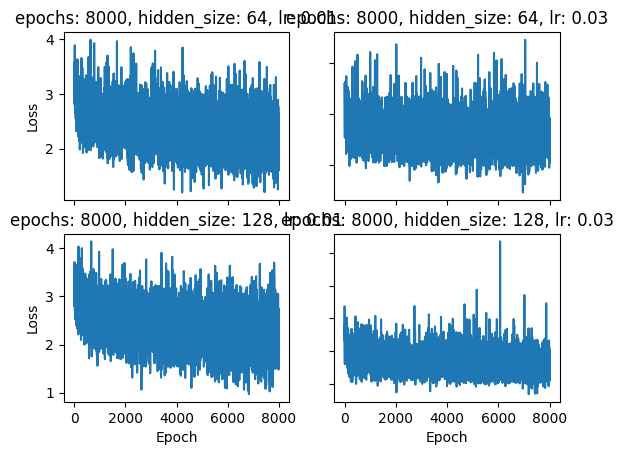

In [47]:
loop_inputs = [
    {
        'epochs': 8000,
        'hidden_size': 64,
        'lr': 0.01
    },
    {
        'epochs': 8000,
        'hidden_size': 64,
        'lr': 0.03
    },
    {
        'epochs': 8000,
        'hidden_size': 128,
        'lr': 0.01
    },
    {
        'epochs': 8000,
        'hidden_size': 128,
        'lr': 0.03
    }
]
loop_results = []

for i, e in enumerate(loop_inputs):
    gennames = Generator(
        epochs=e['epochs'],
        hidden_size=e['hidden_size'],
        lr=e['lr']
    )
    losses = gennames.train()

    # save training results
    loop_results.append({
        'epochs': e['epochs'],
        'hidden_size': e['hidden_size'],
        'lr': e['lr'],
        'losses': losses,
        'max loss': max(losses),
        'min loss': min(losses)
    })

    # print the results
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(loop_results[0]['losses'])
axs[0, 0].set_title('epochs: {}, hidden_size: {}, lr: {}'.format(
    loop_results[0]['epochs'],
    loop_results[0]['hidden_size'],
    loop_results[0]['lr']
))
axs[0, 1].plot(loop_results[1]['losses'])
axs[0, 1].set_title('epochs: {}, hidden_size: {}, lr: {}'.format(
    loop_results[1]['epochs'],
    loop_results[1]['hidden_size'],
    loop_results[1]['lr']
))
axs[1, 0].plot(loop_results[2]['losses'])
axs[1, 0].set_title('epochs: {}, hidden_size: {}, lr: {}'.format(
    loop_results[2]['epochs'],
    loop_results[2]['hidden_size'],
    loop_results[2]['lr']
))
axs[1, 1].plot(loop_results[3]['losses'])
axs[1, 1].set_title('epochs: {}, hidden_size: {}, lr: {}'.format(
    loop_results[3]['epochs'],
    loop_results[3]['hidden_size'],
    loop_results[3]['lr']
))

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

plt.show()

    # # print 5 names
    # letters = ['a', 's', 'd', 'n', 'm', 'z']
    # for i in range(6):
    #     print('Name {}:'.format(i+1))
    #     names = gennames.generate(initial_str=letters[i])
    #     import re
    #     # capitalize the first letter of each char after a newline
    #     names = re.sub(r'\n.', lambda x: x.group().upper(), names.capitalize())
    #     print(names)

# TODO: monitor loss over time
# TODO: randomize the order of the names for each sequence

In [50]:
# # class model

# # references:
# # https://medium.com/data-science-and-machine-learning-at-pluralsight/nickname-generation-with-recurrent-neural-networks-with-pytorch-6fa53de7f289

# class CharLSTM(nn.Module):
#     def __init__(
#         self,
#         charset_size: int,
#         hidden_layer_size: int,
#         embedding_dim: int = 8,
#         num_layers: int = 2,  # Adjusted to match TensorFlow model
#     ):
#         super(CharLSTM, self).__init__()

#         # self.charset_size = charset_size
#         # self.hidden_size = hidden_layer_size
#         # self.embedding_dim = embedding_dim
#         self.num_layers = num_layers
#         # create the embedding
#         self.embedding = nn.Embedding(
#             charset_size,
#             embedding_dim
#         )

#         # self. encoder(...) # model does not include encoder because they are built into the dataset
#         self.lstm = nn.LSTM(
#             embedding_dim,
#             hidden_layer_size,
#             batch_first=True,
#             num_layers=num_layers,
#             dropout=0.5
#         )
#         self.decoder = nn.Linear(hidden_layer_size, charset_size)
#         self.dropout = nn.Dropout(p=0.25)  # Assuming a constant dropout rate
#         self.softmax = nn.LogSoftmax(dim=2)

#     def forward(self, input_tensor, hidden_state):
#         # embedded = self.embedding(input_tensor) # not using this?
#         # output, hidden_state = self.lstm(input_tensor, hidden_state)  # Corrected to use the embedded input
#         embedded = self.embedding(input_tensor) # not using this?
#         output, hidden_state = self.lstm(embedded, hidden_state)  # Corrected to use the embedded input
#         # output = self.decoder(output) # I will handle decoding outside of the model as well
#         output = self.dropout(output)
#         output = self.softmax(output)
#         return output, hidden_state

#     def init_hidden(self):
#         # are the dimensions for the hidden state correct?
#         return (
#             torch.zeros(self.num_layers, 32, self.hidden_size), # example has 1 not 32 for both of these
#             torch.zeros(self.num_layers, 32, self.hidden_size)
#         )


In [49]:
# # initialize the model
# # does the hidden size need to matter in relation to my input data?
# # is this embedding dimension correct?
# embedding_dimension = 10
# model = CharLSTM(num_chars, hidden_size=128, embedding_dim=embedding_dimension, num_layers=2)
# print(model)

In [48]:
# # references
# # https://medium.com/data-science-and-machine-learning-at-pluralsight/nickname-generation-with-recurrent-neural-networks-with-pytorch-6fa53de7f289

# import typing

# # TensorPair = typing.Tuple[torch.LongTensor, torch.LongTensor]

# def tensorize(word: str) -> torch.Tensor:
#     input_tensor = torch.Tensor([char2idx[char] for char in word])

#     # eos = torch.zeros(1).type(torch.LongTensor) + (num_chars - 1)
#     # target_tensor = torch.cat((letter_indices[1:], eos))

#     return input_tensor

In [51]:
# # references
# # https://medium.com/data-science-and-machine-learning-at-pluralsight/nickname-generation-with-recurrent-neural-networks-with-pytorch-6fa53de7f289

# # TODO: this, along with the model, needs to be adapted to my dataset

# # draw a sample from the model
# def sample(
#     seed: str,
#     max_len: int = 12,
#     break_on_eos: bool = True,
#     eval_mode: bool = True
# ) -> str:
#     # optionally set eval mode to disable dropout
#     if eval_mode:
#         model.eval()

#     # disable gradient computation
#     with torch.no_grad():
#         input_tensor = tensorize(seed)
#         hidden = model.init_hidden()

#         # add the length-1 batch dimension to match output from Dataset
#         # TODO: needed? if so, why?
#         input_tensor = input_tensor.unsqueeze(0)

#         output_name = seed
#         for _ in range(max_len):
#             out, hidden = model(input_tensor, hidden)
#             _, topi = out[:, -1, :].topk(1)  # grab top prediction for last character
#             next_char = idx2char[int(topi.squeeze())]

#             if break_on_eos and (next_char == "<EOS>"):
#                 break
#             output_name += next_char
#             input_tensor = topi
#         # for _ in range(max_len):
#         #     output, hidden = model(input_tensor, hidden)
#         #     output = output.squeeze(0)

#         #     # Sample from the network as a multinomial distribution
#         #     _, topi = output.topk(1)
#         #     topi = topi[0][0]
#         #     if topi == num_chars - 1:
#         #         break
#         #     else:
#         #         letter = idx2char[topi.item()]
#         #         output_name += letter
    
#     # put it back into training mode
#     model.train()
#     return output_name

In [52]:
# import random
# import string

# # get samples
# for _ in range(10):
#     seed = random.choice(string.ascii_lowercase)
#     print(f"{seed} --> {sample(seed)}")

In [53]:
# # Training
# import time

# # Assuming you have input_data and target_data loaded and preprocessed
# # Adjust batch_size, epochs, and other parameters based on your requirements

# batch_size = 32
# epochs = 100
# latent_dim = 64
# verbosity = 1
# store_model = True

# input_data: torch.Tensor = torch.from_numpy(X).long()
# target_data: torch.Tensor = torch.from_numpy(Y).long()

# model = CharLSTM(charset_size=num_chars, hidden_size=latent_dim)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.RMSprop(model.parameters(), lr=0.01)

# start = time.time()
# print('Start training for {} epochs'.format(epochs))
# for epoch in range(epochs):
#     hidden = model.init_hidden(batch_size)

#     for i in range(0, len(input_data), batch_size):
#         input_batch = input_data[i:i+batch_size].transpose(0, 1)
#         target_batch = target_data[i:i+batch_size]

#         optimizer.zero_grad()

#         # TODO: fix error here
#         output, hidden = model(input_batch, hidden)
#         loss = criterion(output.view(-1, num_chars), target_batch.view(-1))
#         loss.backward()

#         optimizer.step()

#     if epoch % verbosity == 0:
#         print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
# end = time.time()
# print('Finished training. Time elapsed:', (end - start)/60, 'min')

# # Save the model if store_model is True
# if store_model:
#     torch.save(model.state_dict(), 'pytorch_model.pth')

In [54]:
# # Generate names
# import torch
# import numpy as np

# gen_amount = 10

# # Assuming model is already defined and loaded
# model.eval()

# # Start sequence generation from end of the input sequence
# sequence = concatenated_names[-(max_sequence_length - 1):] + '\n'

# new_names = []

# print('{} new names are being generated'.format(gen_amount))

# with torch.no_grad():
#     while len(new_names) < gen_amount:
#         # Vectorize sequence for prediction
#         x = torch.zeros((1, max_sequence_length), dtype=torch.long)
#         for i, char in enumerate(sequence):
#             x[0, i] = char2idx[char]

#         hidden_state = model.init_hidden(1)
#         x = x.unsqueeze(0)  # Add batch dimension

#         # Predict next char
#         output, hidden_state = model(x, hidden_state)
#         probs = torch.exp(output[:, -1, :])  # Take the last output
#         next_idx = torch.multinomial(probs, 1).item()
#         next_char = idx2char[next_idx]
#         sequence = sequence[1:] + next_char

#         # New line means we have a new name
#         if next_char == '\n':
#             gen_name = [name for name in sequence.split('\n')][1]

#             # Never start a name with two identical chars
#             if len(gen_name) > 2 and gen_name[0] == gen_name[1]:
#                 gen_name = gen_name[1:]

#             # Discard all names that are too short
#             if len(gen_name) > 2:
#                 # Only allow new and unique names
#                 if gen_name not in pokemon_names + new_names:
#                     new_names.append(gen_name.capitalize())

#             if len(new_names) % (gen_amount // 10) == 0:
#                 print('Generated {}'.format(len(new_names)))


In [55]:
# # print the generated names
# print_first_n = min(10, gen_amount)

# print('First {} generated names:'.format(print_first_n))
# for name in new_names[:print_first_n]:
#     print(name)